In [65]:
import numpy as np
import pandas as pd
import os 

In [66]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

In [67]:
ann_df = pd.read_csv(
    'annotations.csv'
)
meta_df = pd.read_csv(
    'metadata.csv'
)
ann_df.shape


(27552, 9)

In [68]:
train_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[:int(len(meta_df)*0.7)]
validation_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.7):int(len(meta_df)*0.9)]
test_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.9):len(meta_df)]




In [69]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [70]:
features_dir = "audio_features"
labels_dir = "labels"

import itertools
def read_files(file_names):
    X_train = []
    Y_train = {c: [] for c in categories}  # Initialize label dictionary
    
    for f in file_names:
        features_mel = np.load(os.path.join(features_dir, f.split('.')[0] + '.npz'))["melspectrogram"]

      
        X_train.append(features_mel)
        
        # Load and process labels
        y = np.load(os.path.join(labels_dir, f.split('.')[0] + '_labels.npz'))
        for c in categories:
            _y = aggregate_labels(y[c])
            Y_train[c].extend(list(itertools.chain.from_iterable(_y))) # Match length
    
    X_train = np.concatenate(X_train)
    return X_train, Y_train

In [71]:
from sklearn.preprocessing import StandardScaler
def preprocessing(array):
    s=StandardScaler()
    scaled_array = s.fit_transform(array)
    scalar =s.fit(array)
    return scaled_array,scalar.mean_,scalar.scale_

In [72]:
train_x,train_y = read_files(train_filename)
val_x, val_y = read_files(validation_filename)
test_x, test_y = read_files(test_filename)

In [73]:
scaled_train_x,mu,std =preprocessing(train_x)
scaled_validation_x = (val_x - mu)/std
scaled_test_x = (test_x - mu)/std

In [74]:
train_y = np.array([train_y[cls] for cls in categories]).T
val_y = np.array([val_y[cls] for cls in categories]).T
test_y = np.array([test_y[cls] for cls in categories]).T
train_y.shape

(1078243, 58)

In [100]:
import torch
import torch.nn as nn

class LSTMAED(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.2,bidirectional=False):
        super(LSTMAED, self).__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )
        if bidirectional is True:
            linear= nn.Linear(hidden_dim * 2, num_classes)
        else:
            linear= nn.Linear(hidden_dim, num_classes)
        self.classifier = nn.Sequential( linear)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)  
        out = self.classifier(lstm_out)  
        return out

In [101]:
lstm=LSTMAED(64,128,58).to("cuda")
BiLSTM=LSTMAED(64,128,58,bidirectional=True).to("cuda")

In [102]:
def train_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda" 
    model.to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0] * 58, device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    training_loss = []
    validation_loss = []

    # Datasets
    batch_size = 32
    scaled_train_x_tensor = torch.tensor(scaled_train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.float32)
    scaled_validation_x_tensor = torch.tensor(scaled_validation_x, dtype=torch.float32)
    val_y_tensor = torch.tensor(val_y, dtype=torch.float32)

    train_dataset = TensorDataset(scaled_train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(scaled_validation_x_tensor, val_y_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    num_epochs = 12

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            preds = (sigmoid(output) > 0.5).int()
            targets = y_batch.int()
            train_correct += (preds == targets).sum().item()
            train_total += targets.numel()

        train_accuracy = train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)
        training_loss.append(avg_train_loss)

        # ----------- Validation and Metrics -----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                val_output = model(x_val)
                val_loss += criterion(val_output, y_val).item()

                probs = sigmoid(val_output)
                preds = (probs > 0.5).int()
                targets = y_val.int()

                all_preds.append(preds)
                all_targets.append(targets)

        avg_val_loss = val_loss / len(val_loader)
        validation_loss.append(avg_val_loss)

        # Stack predictions
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute metrics
        TP = (all_preds & all_targets).sum(dim=0).float()
        FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
        FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
        TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)
        tnr = TN / (TN + FP + 1e-8)
        balanced_acc = (recall + tnr) / 2

        avg_precision = precision.mean().item()
        avg_recall = recall.mean().item()
        avg_f1 = f1.mean().item()
        avg_bal_acc = balanced_acc.mean().item()
        val_accuracy = (all_preds == all_targets).float().mean().item()

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"Train Loss:                  {avg_train_loss:.4f}")
        print(f"Train Accuracy:              {train_accuracy:.4f}")
        print(f"Val Loss:                    {avg_val_loss:.4f}")
        print(f"Validation Accuracy:         {val_accuracy:.4f}")
        print(f"Precision:                   {avg_precision:.4f}")
        print(f"Recall:                      {avg_recall:.4f}")
        print(f"F1 Score:                    {avg_f1:.4f}")
        print(f"Average Balanced Accuracy:   {avg_bal_acc:.4f}")



    return training_loss, validation_loss, {
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc,
        "val_accuracy": val_accuracy
    }

In [103]:
def test_model(model):
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset
    from torch.nn.functional import sigmoid

    device = "cuda" 
    model.to(device)
    model.eval()  # Set model to evaluation mode
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0] * 58, device=device))

    # Datasets
    batch_size = 32
    scaled_test_x_tensor = torch.tensor(scaled_test_x, dtype=torch.float32).to(device)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

    test_dataset = TensorDataset(scaled_test_x_tensor, test_y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    test_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)
            output = model(x_test)
            test_loss += criterion(output, y_test).item()

            probs = sigmoid(output)
            preds = (probs > 0.5).int()
            all_preds.append(preds)
            all_targets.append(y_test.int())

    # Calculate average test loss
    avg_test_loss = test_loss / len(test_loader)

    # Stack predictions for metric calculations
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate metrics
    TP = (all_preds & all_targets).sum(dim=0).float()
    FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
    FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
    TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    f1 = (2 * precision * recall) / (precision + recall + 1e-8)
    tnr = TN / (TN + FP + 1e-8)
    balanced_acc = (recall + tnr) / 2

    avg_precision = precision.mean().item()
    avg_recall = recall.mean().item()
    avg_f1 = f1.mean().item()
    avg_bal_acc = balanced_acc.mean().item()
    test_accuracy = (all_preds == all_targets).float().mean().item()

    # Print results
    print("\nTest Results")
    print(f"Test Loss:                 {avg_test_loss:.4f}")
    print(f"Test Accuracy:             {test_accuracy:.4f}")
    print(f"Precision:                 {avg_precision:.4f}")
    print(f"Recall:                    {avg_recall:.4f}")
    print(f"F1 Score:                  {avg_f1:.4f}")
    print(f"Average Balanced Accuracy: {avg_bal_acc:.4f}")

    return {
        "test_loss": avg_test_loss,
        "test_accuracy": test_accuracy,
        "precision": avg_precision,
        "recall": avg_recall,
        "f1": avg_f1,
        "balanced_accuracy": avg_bal_acc
    }


In [104]:
tr_loss, val_loss, eval_dict =  train_model(lstm)


Epoch 1/12
Train Loss:                  0.3700
Train Accuracy:              0.9466
Val Loss:                    0.3815
Validation Accuracy:         0.9433
Precision:                   0.1675
Recall:                      0.2913
F1 Score:                    0.1831
Average Balanced Accuracy:   0.6220

Epoch 2/12
Train Loss:                  0.3286
Train Accuracy:              0.9468
Val Loss:                    0.3812
Validation Accuracy:         0.9430
Precision:                   0.1508
Recall:                      0.3107
F1 Score:                    0.1899
Average Balanced Accuracy:   0.6314

Epoch 3/12
Train Loss:                  0.3136
Train Accuracy:              0.9472
Val Loss:                    0.3829
Validation Accuracy:         0.9411
Precision:                   0.1466
Recall:                      0.3255
F1 Score:                    0.1907
Average Balanced Accuracy:   0.6377

Epoch 4/12
Train Loss:                  0.3047
Train Accuracy:              0.9476
Val Loss:       

In [105]:

tr_loss_bi, val_loss_bi, eval_dict_bi =  train_model(BiLSTM)


Epoch 1/12
Train Loss:                  0.3392
Train Accuracy:              0.9470
Val Loss:                    0.3875
Validation Accuracy:         0.9416
Precision:                   0.1488
Recall:                      0.3190
F1 Score:                    0.1906
Average Balanced Accuracy:   0.6349

Epoch 2/12
Train Loss:                  0.2831
Train Accuracy:              0.9501
Val Loss:                    0.4016
Validation Accuracy:         0.9427
Precision:                   0.1529
Recall:                      0.3334
F1 Score:                    0.2004
Average Balanced Accuracy:   0.6427

Epoch 3/12
Train Loss:                  0.2624
Train Accuracy:              0.9525
Val Loss:                    0.4145
Validation Accuracy:         0.9423
Precision:                   0.1522
Recall:                      0.3391
F1 Score:                    0.2031
Average Balanced Accuracy:   0.6453

Epoch 4/12
Train Loss:                  0.2506
Train Accuracy:              0.9541
Val Loss:       

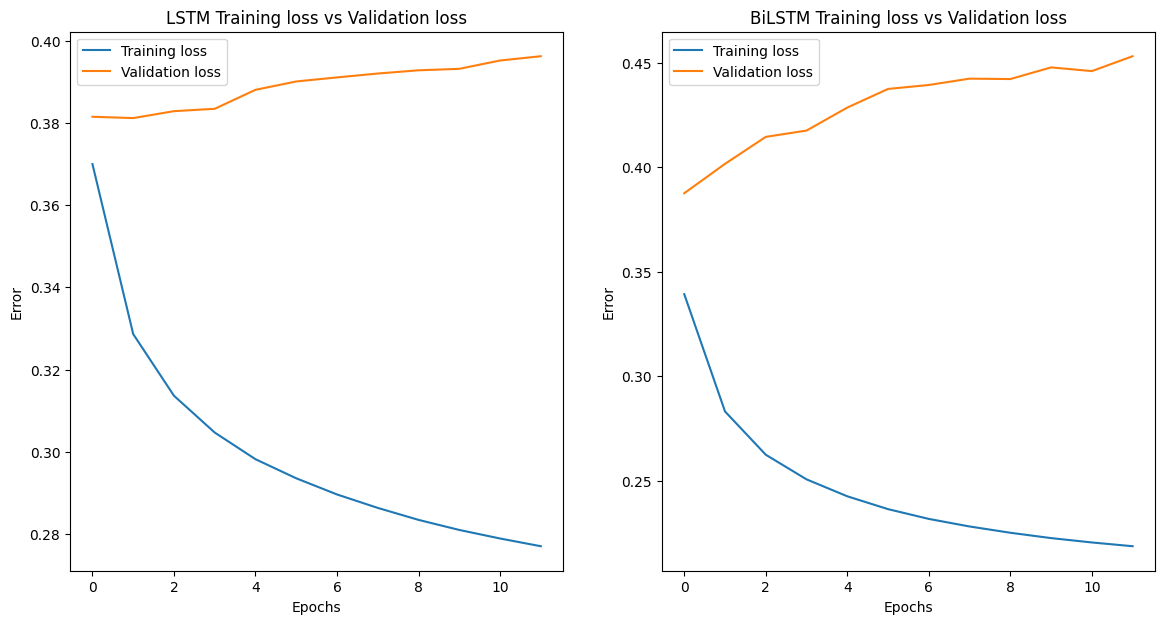

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
ax[0].plot(range(len(tr_loss)), tr_loss, label="Training loss")
ax[0].plot(range(len(val_loss)), val_loss, label="Validation loss")
ax[0].set_title("LSTM Training loss vs Validation loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Error")
ax[0].legend()

ax[1].plot(range(len(tr_loss_bi)), tr_loss_bi, label="Training loss")
ax[1].plot(range(len(val_loss_bi)), val_loss_bi, label="Validation loss")
ax[1].set_title("BiLSTM Training loss vs Validation loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Error")
ax[1].legend()

plt.show()

In [107]:
test_model(lstm)


Test Results
Test Loss:                 0.4223
Test Accuracy:             0.9438
Precision:                 0.1486
Recall:                    0.3233
F1 Score:                  0.1966
Average Balanced Accuracy: 0.6383


{'test_loss': 0.42227933894853625,
 'test_accuracy': 0.9438167810440063,
 'precision': 0.14860953390598297,
 'recall': 0.32329636812210083,
 'f1': 0.19664090871810913,
 'balanced_accuracy': 0.6383132934570312}

In [108]:
test_model(BiLSTM)


Test Results
Test Loss:                 0.4860
Test Accuracy:             0.9440
Precision:                 0.1364
Recall:                    0.3072
F1 Score:                  0.1850
Average Balanced Accuracy: 0.6307


{'test_loss': 0.4859591168568399,
 'test_accuracy': 0.944010317325592,
 'precision': 0.1363573670387268,
 'recall': 0.3072167634963989,
 'f1': 0.18502245843410492,
 'balanced_accuracy': 0.6306852102279663}

In [109]:
torch.save(lstm.state_dict(), 'lstm_weights.pth')
torch.save(lstm, 'lstm_full_model.pth')

In [112]:
torch.save(BiLSTM.state_dict(), 'bilstm_weights.pth')
torch.save(BiLSTM, 'bilstm_full_model.pth')